In [1]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
from pathlib import Path
import hydra_zen
from omegaconf import OmegaConf 
import torch
import xarray as xr
import lightning as L
import numpy as np
import importlib
import matplotlib.pyplot as plt
import glob
from data_module import WindDirectionDataModule
import simple_conv
importlib.reload(simple_conv)
from simple_conv import MyModel
import math
from scipy import stats
import pandas as pd

# Use function

In [3]:
def load_model(model_path, inc, hid, depth, model_mdn=True, down=4, weight_decay=None, num_gaussians=2):
    checkpoint = torch.load(model_path)
    model = MyModel(inc=inc, hid=hid, depth=depth, model_mdn=model_mdn, down=down, weight_decay=weight_decay, num_gaussians=num_gaussians)
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint


def load_data(path, checkpoint, inc=2, pol='VV'):
    data_module = WindDirectionDataModule(test_data_paths=path, inc=inc, pol=pol)
    data_module.train_mean = checkpoint['train_mean']
    data_module.train_std = checkpoint['train_std']
    data_module.setup(stage='predict')
    dataloader = data_module.test_dataloader()
    return dataloader, data_module


def predict(model, dataloader, model_mdn=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    y_pred = []
    uncertainty = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            X, _ = batch
            X = X.to(device)
            
            if model_mdn:
                preds, uncer = model(X)
                y_pred.append(preds)
                uncertainty.append(uncer)
            else:
                preds = model(X)
                y_pred.append(preds)
        y_pred = torch.concat(y_pred).cpu()
        
        if model_mdn:
            uncertainty = torch.cat(uncertainty, dim=0).cpu()
            return y_pred.squeeze(), uncertainty
        
        return y_pred.squeeze()
        

def loss_cos(y_true, y_pred, ambi=False):
    err = y_pred - y_true
    if not ambi:
        err = err / 2
    loss = 1 - torch.square(torch.cos(err))
    return torch.mean(loss)

In [4]:
def get_histogram_2d_variables(x_column, y_column, nbins=100):
    x_min, x_max = np.min(x_column), np.max(x_column)
    y_min, y_max = np.min(y_column), np.max(y_column)
    
    kernel = stats.gaussian_kde([x_column, y_column])
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        
    return xi, yi, zi.reshape(xi.shape)

def hist2d_prediction_vs_reference(x, y, pred_std, pol, sat, title, mod=False, delta_time=30):
    if pol == 'VV' or pol == 'VH' or pol == 'VV-VH':
        color = 'Greens'
        color_h = 'green'
    elif pol == 'HH' or pol == 'HV' or pol == 'HH-HV':
        color = 'Blues'
        color_h = '#1f77b4'
        
    X, Y, Z = get_histogram_2d_variables(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=(6, 1), height_ratios=(1, 6),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
        
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.pcolormesh(X, Y, Z, shading='auto', cmap=color)
    ax.set_xlabel('Reference angle (°)', fontsize=14)
    ax.set_ylabel('Predicted angle (°)', fontsize=14)
    ax.set_xlim(0, 180)
    ax.set_ylim(0, 180)
    
    nbins = 90
    binwidth = 180 / nbins

    bins = np.arange(0, 180 + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, alpha=0.75, color=color_h)
    ax_histx.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histx.set_xlim(0, 180)
    ax_histy.hist(y, bins=bins, orientation='horizontal', alpha=0.75, color=color_h)
    ax_histy.grid(linestyle='--', color='gray', alpha=0.9)
    ax_histy.set_ylim(0, 180)

    ax.grid(linestyle='--', color='gray', alpha=0.9)
    
    x_series = pd.Series(x)
    y_series = pd.Series(y)
    
    diff_serie = (y_series - x_series % 180).apply(lambda v: -1 * np.sign(v) * 180 + v if np.abs(v) > 90 else v)
    bias = diff_serie.mean()
    std = diff_serie.std()
    nb_points = len(x)

    txt_str = 'Number of points: %d \nBias: %.2f° | Std: %.2f°' % (nb_points, bias, std)
    
    if pred_std:
        title_str = f'{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min, STD predicted: [0 - {pred_std.values.max():.2f}]°'
    else:
        if mod:
            title_str = f'{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min {title} mod90'
            
        else:
            title_str = f'{sat} ({pol}) predicted angle & HY2b angle\nDiff_time_max: {delta_time}min {title}'
    props = dict(boxstyle='square', facecolor='white')
        
    ax.text(0.05, 0.95, txt_str, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.plot([0, 180], [0, 180], color='k', linestyle='--')
    plt.suptitle(title_str, fontsize=20)
        
    plt.show()


In [5]:
mod = '2024-08-29/15-47-01/15/wind_direction_model/2_4_128_7_True_0.0001_ren_ds'
model_old = f'/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/simple_conv/multirun/{mod}/checkpoints/best-checkpoint.ckpt'
inc = 2
model_mdn = True
weight_decay = 1e-4
model, checkpoint = load_model(model_path=model_old, inc=inc, hid=128, depth=7, model_mdn=model_mdn, down=4, weight_decay=weight_decay, num_gaussians=2)


# Renaud ds

In [16]:
pol = 'VV'
sat = 'RS2'
if sat == 'S1':
    theta_diff = 30
else:
    theta_diff = 60
if pol == 'VV':
    path = f"/raid/localscratch/jrmiadan/analyse/analyse_ds/{sat.lower()}_ds_{pol.lower()}_vh.nc"
elif pol == 'HH':
    path = f"/raid/localscratch/jrmiadan/analyse/analyse_ds/{sat.lower()}_ds_{pol.lower()}_hv.nc"
    
ds = xr.open_dataset(path)


In [17]:
# # Cyclone
# sat = 'S1'
# pol = 'VV'
# if sat == 'S1':
#     theta_diff = 30
# else:
#     theta_diff = 60
# path = '/raid/localscratch/jrmiadan/analyse/analyse_ds/s1_cyclone_ds_vv_vh.nc'
# ds = xr.open_dataset(path)


In [18]:
dataloader, data_module = load_data(path=path, checkpoint=checkpoint, inc=inc, pol=pol)
if model_mdn:
    y_pred, uncertainty = predict(model, dataloader, model_mdn=model_mdn)
else:
    y_pred = predict(model, dataloader, model_mdn=model_mdn)


In [19]:
heading_angles = ds.sel(pol=pol).ground_heading.values[:,0,0]
y_pred_norm = (np.rad2deg(np.array(y_pred)) + heading_angles)%180
y_hy2b = ds.sel(pol=pol).hy2b_wind_direction.values
# y_pred_rob = ds.sel(pol=pol).mean_wind_direction.values

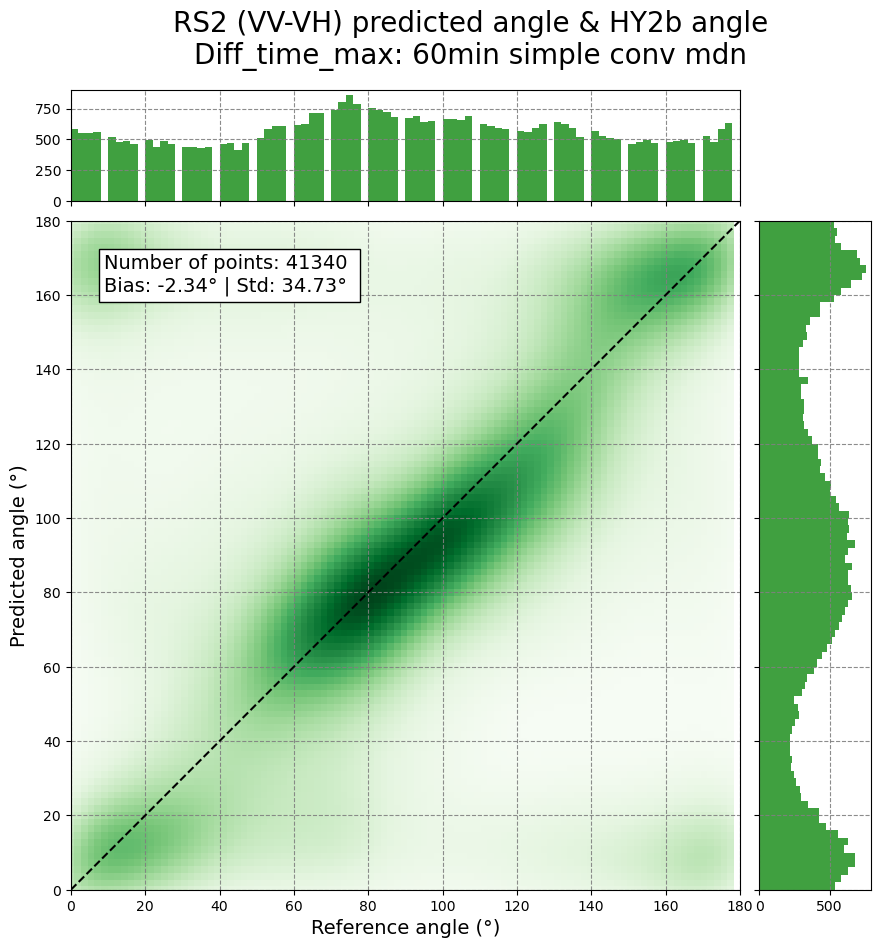

In [20]:
pol_plot = 'VV-VH' if pol == 'VV' else 'HH-HV'
hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=y_pred_norm, pred_std=None, title='simple conv mdn', pol=pol_plot, sat=sat, delta_time=theta_diff)

In [10]:
# hist2d_prediction_vs_reference(x=np.array(y_hy2b)%180, y=np.array(y_pred_rob%180), pred_std=None, title='Robin Model', pol='VV')

In [12]:
y_true = torch.tensor(np.deg2rad(y_hy2b%180), dtype=torch.float32)
y_pred = torch.tensor(np.deg2rad(y_pred_norm%180), dtype=torch.float32)

test_loss = loss_cos(y_true, y_pred)
print(test_loss)

tensor(0.1578)


In [12]:
ds_path = "/raid/localscratch/jrmiadan/analyse/cnn_project/pythonProject1/dataset/test_robin.nc"
dataloader, data_module = load_data(path=ds_path, checkpoint=checkpoint, inc=inc)
y_pred = predict(model, dataloader, model_mdn=False)
# y_pred, uncertainty = predict(model, dataloader, model_mdn=True)


AssertionError: Size mismatch between tensors

In [ ]:
ds = xr.open_dataset(ds_path)

In [ ]:
y_era5 = (ds.sel(pol='VV').era5_angle.values)%180
heading_angles = ds.sel(pol='VV').ground_heading.values
y_pred_norm = np.add(np.rad2deg(np.array(y_pred)), heading_angles)%180

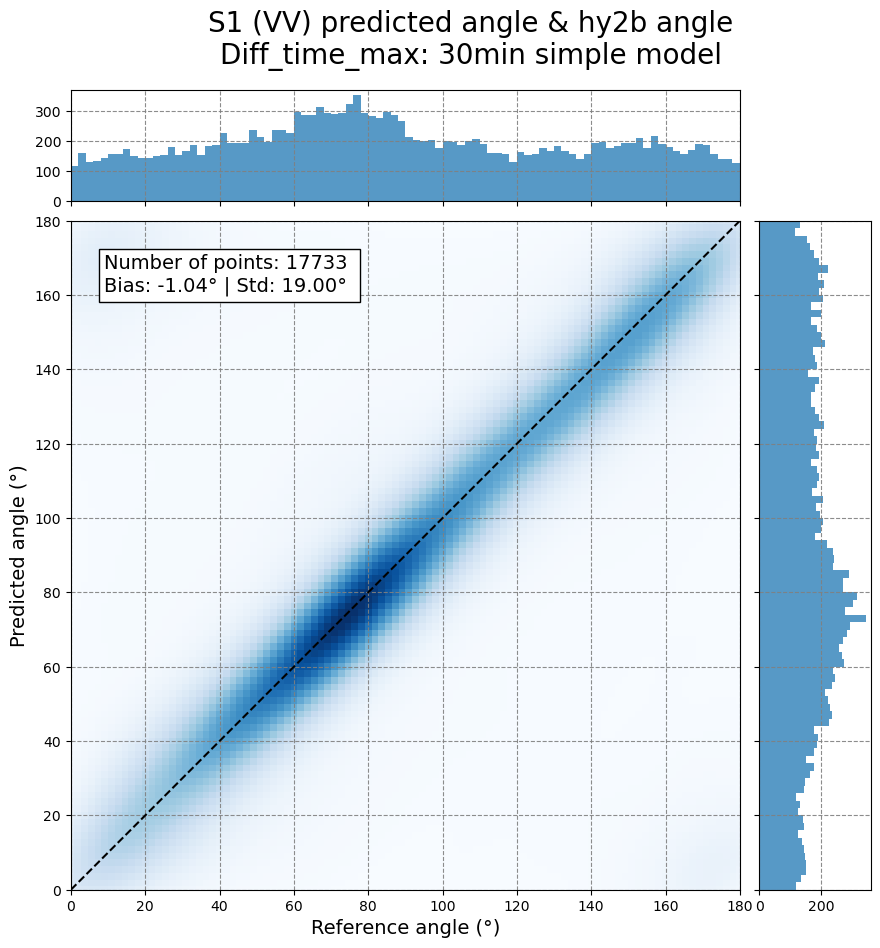

In [18]:
hist2d_prediction_vs_reference(x=y_era5, y=y_pred_norm, pred_std=None, title='simple model', pol='VV')

In [19]:
y_pred = ds.sel(pol='VV').pred_angle.values%180
# hist2d_prediction_vs_reference(x=y_era5, y=y_pred, pred_std=None, title='Robin model', pol='VV')

In [20]:
df_test = pd.DataFrame({
    'reference_angle' : y_era5,
    'Robin_pred' : y_pred,
    'Simple_model' : y_pred_norm
})

y_true = torch.tensor(np.deg2rad(df_test['reference_angle'].values), dtype=torch.float32)
y_pred_rob = torch.tensor(np.deg2rad(df_test['Robin_pred'].values), dtype=torch.float32)

rob_test_loss = loss_cos(y_true, y_pred_rob)

y_pred_ren = torch.tensor(np.deg2rad(df_test['Simple_model'].values), dtype=torch.float32)

ren_test_loss = loss_cos(y_true, y_pred_ren)
print(f"Robin loss:{rob_test_loss}\nRenaud loss:{ren_test_loss}")

Robin loss:0.07488402724266052
Renaud loss:0.07365257292985916


# Analyse coloc